# Music Key Estimation


## Constants


In [1]:
import pathlib

DATA_FOLDER = pathlib.Path("data")
AUDIO_DATA_FOLDER = pathlib.Path("data/audio")

## Notebook Setup

In [2]:
from matplotlib import rcParams

%matplotlib inline

rcParams["figure.figsize"] = 14, 8  # In inches

## Obtaining Data


Let's get all the audio files within the data folder.

In [3]:
import os

allFiles = os.listdir(AUDIO_DATA_FOLDER)

Let's get only the audio files present in the folder.


In [4]:
audioFiles = [x for x in allFiles if x.lower().endswith(".mp3")]

Let's look at some of the audio files present.

In [5]:
print("Number of audio files:", len(audioFiles))
print(audioFiles)

Number of audio files: 25
['299482.LOFI.mp3', '297501.LOFI.mp3', '5324261.LOFI.mp3', '299995.LOFI.mp3', '3218510.LOFI.mp3', '718543.LOFI.mp3', '3198699.LOFI.mp3', '299932.LOFI.mp3', '167955.LOFI.mp3', '297261.LOFI.mp3', '5611816.LOFI.mp3', '297806.LOFI.mp3', '4616741.LOFI.mp3', '299862.LOFI.mp3', '4917696.LOFI.mp3', '5943904.LOFI.mp3', '5497183.LOFI.mp3', '1196189.LOFI.mp3', '297541.LOFI.mp3', '297273.LOFI.mp3', '37745.LOFI.mp3', '1115626.LOFI.mp3', '297494.LOFI.mp3', '1410568.LOFI.mp3', '299767.LOFI.mp3']


Now let's get the key annotations of the audio files.

The key annotations are stored in a file named `annotations.txt`. However, it is formatted like a tab-separated values (TSV) file. Thus we shall read it in as a TSV file and process it.


In [6]:
import pandas
allAnnotations = pandas.read_csv(DATA_FOLDER / "annotations.txt", sep="\t")

Let's analyse the data.


In [7]:
allAnnotations

,ID,MANUAL KEY,C
0,5061,D# minor,2
1,5881,A major,2
2,7217,F minor,2
3,10359,D minor,2
4,10981,-,0
...,...,...,...
1481,6532021,C# minor,1
1482,6535130,E minor,2
1483,6537998,E major,2
1484,6563157,B minor,2


Some things to note about the data:
- Some rows do not have a `MANUAL KEY`. These rows need to be removed.
- The `C` value is the *confidence value* of the key estimate. Higher confidence values means that the key value is more likely to be correct.
    - Interestingly, rows without a manual key have a confidence value of `0`. This reveals a quick way to remove non-key rows.
- Some rows have more than one `MANUAL KEY` (see row 47 with `ID = 61578`). For consistency, we shall pick the first key that appears in that `MANUAL KEY` column.

After cleaning up the data, we can remove the `C` column as it is not helpful when we are estimating the key of the music.

Let's run the processes described above.


In [8]:
# Handle the rows with more than one manual key
numRows = len(allAnnotations)

for index in range(numRows):
    # Get the "MANUAL KEY" column's value
    manualKey = allAnnotations.iloc[index]["MANUAL KEY"]

    # Split the key entry by a forward slash (/)
    manualKeys = manualKey.split("/")

    # Keep only the first key
    manualKey = manualKeys[0]

    # Update the dataframe, by adding a new "KEY" column in place of the "MANUAL KEY" column
    allAnnotations.loc[index, "KEY"] = manualKey.strip().upper()

# Remove all rows with a confidence value of 0 (i.e. no manual key)
allAnnotations.drop(allAnnotations[allAnnotations["C"] == 0].index, inplace=True)

# Remove the "C" and "MANUAL KEY" column
allAnnotations.drop(columns=["C", "MANUAL KEY"], inplace=True)

Let's look at the updated data.


In [9]:
allAnnotations

,ID,KEY
0,5061,D# MINOR
1,5881,A MAJOR
2,7217,F MINOR
3,10359,D MINOR
5,11077,G MINOR
...,...,...
1481,6532021,C# MINOR
1482,6535130,E MINOR
1483,6537998,E MAJOR
1484,6563157,B MINOR


Now we have to reindex the rows of the dataframe, as some rows have been removed during the data augmentation step above.


In [10]:
allAnnotations.reset_index(drop=True, inplace=True)  # We don't want the old index being added to the dataframe
allAnnotations

,ID,KEY
0,5061,D# MINOR
1,5881,A MAJOR
2,7217,F MINOR
3,10359,D MINOR
4,11077,G MINOR
...,...,...
1385,6532021,C# MINOR
1386,6535130,E MINOR
1387,6537998,E MAJOR
1388,6563157,B MINOR


Let's now further process the `KEY` column.

We first define a helper function that determines what the numeric value of each music key will be.
- For example, the key of `C major` will have the numeric value of `0`, `C♯ major` has the numeric value `7`, and `C♭ major` will have the numeric value of `-7`.

In [11]:
def fancify_music_string(music_key):
    return music_key.replace("#", "♯").replace("b", "♭")

def get_numeric_value(music_key):
    # Fancify music string
    music_key = fancify_music_string(music_key)

    # Ensure the music key is in title case
    music_key = music_key.title()

    # Now we have the horrifying `if` cases to get numeric value
    if music_key in ["C♭ Major", "A♭ Minor"]:
        return -7
    elif music_key in ["G♭ Major", "E♭ Minor"]:
        return -6
    elif music_key in ["D♭ Major", "B♭ Minor"]:
        return -5
    elif music_key in ["A♭ Major", "F Minor"]:
        return -4
    elif music_key in ["E♭ Major", "C Minor"]:
        return -3
    elif music_key in ["B♭ Major", "G Minor"]:
        return -2
    elif music_key in ["F Major", "D Minor"]:
        return -1
    elif music_key in ["C Major", "A Minor"]:
        return 0
    elif music_key in ["G Major", "E Minor"]:
        return 1
    elif music_key in ["D Major", "B Minor"]:
        return 2
    elif music_key in ["A Major", "F♯ Minor"]:
        return 3
    elif music_key in ["E Major", "C♯ Minor"]:
        return 4
    elif music_key in ["B Major", "G♯ Minor"]:
        return 5
    elif music_key in ["F♯ Major", "D♯ Minor"]:
        return 6
    elif music_key in ["C♯ Major", "A♯ Minor"]:
        return 7
    else:
        raise ValueError(f"Unknown key {music_key}")


We now split the `MANUAL KEY` column into a `NUMERIC KEY` column and a `MODE` column.
- The `NUMERIC KEY` column will contain numeric value of the home key.
- The `MODE` column will contain either `MAJOR` or `MINOR`.

In [12]:
numRows = len(allAnnotations)

for index in range(numRows):
    # Get the "KEY" column's value
    key = allAnnotations.iloc[index]["KEY"]

    # Get numeric value of the key
    try:
        numVal = get_numeric_value(key)
    except ValueError:
        numVal = -1234  # Marks invalid

    # Determine the mode of the key
    mode = key.split(" ")[1].upper()

    # Update the dataframe
    allAnnotations.loc[index, "NUMERIC KEY"] = numVal
    allAnnotations.loc[index, "MODE"] = mode

# Drop any row with no "NUMERIC KEY" value
allAnnotations.drop(allAnnotations[allAnnotations["NUMERIC KEY"] == -1234].index, inplace=True)
allAnnotations = allAnnotations.astype({"NUMERIC KEY": int})

Let's see the updated annotations dataframe.

In [13]:
allAnnotations.reset_index(drop=True, inplace=True)  # We don't want the old index being added to the dataframe
allAnnotations

,ID,KEY,NUMERIC KEY,MODE
0,5061,D# MINOR,6,MINOR
1,5881,A MAJOR,3,MAJOR
2,7217,F MINOR,-4,MINOR
3,10359,D MINOR,-1,MINOR
4,11077,G MINOR,-2,MINOR
...,...,...,...,...
1269,6532021,C# MINOR,4,MINOR
1270,6535130,E MINOR,1,MINOR
1271,6537998,E MAJOR,4,MAJOR
1272,6563157,B MINOR,2,MINOR


We now need to keep only the IDs where we have both an audio file and an annotation match.

In [14]:
# Get all IDs
audioFileIDs = set(int(x.split(".")[0]) for x in audioFiles)
annotationFileIDs = set(allAnnotations["ID"].to_list())

# Find their intersection
relevantIDs = audioFileIDs.intersection(annotationFileIDs)

What are these relevant IDs?


In [15]:
relevantIDs

{37745,
 167955,
 297261,
 297273,
 297494,
 297501,
 297541,
 299482,
 299767,
 299862,
 299932,
 299995,
 718543,
 1115626,
 1196189,
 1410568,
 3198699,
 4917696,
 5324261,
 5497183,
 5943904}

Now keep audio files and annotation data that is relevant to us.

In [16]:
relevantAudioFiles = []
for filename in audioFiles:
    if int(filename.split(".")[0]) in relevantIDs:
        relevantAudioFiles.append(filename)

relevantAnnotations = allAnnotations[allAnnotations["ID"].isin(relevantIDs)]
relevantAnnotations.reset_index(drop=True, inplace=True)

Display this data.

In [17]:
relevantAudioFiles

['299482.LOFI.mp3',
 '297501.LOFI.mp3',
 '5324261.LOFI.mp3',
 '299995.LOFI.mp3',
 '718543.LOFI.mp3',
 '3198699.LOFI.mp3',
 '299932.LOFI.mp3',
 '167955.LOFI.mp3',
 '297261.LOFI.mp3',
 '299862.LOFI.mp3',
 '4917696.LOFI.mp3',
 '5943904.LOFI.mp3',
 '5497183.LOFI.mp3',
 '1196189.LOFI.mp3',
 '297541.LOFI.mp3',
 '297273.LOFI.mp3',
 '37745.LOFI.mp3',
 '1115626.LOFI.mp3',
 '297494.LOFI.mp3',
 '1410568.LOFI.mp3',
 '299767.LOFI.mp3']

In [18]:
relevantAnnotations

,ID,KEY,NUMERIC KEY,MODE
0,37745,E MINOR,1,MINOR
1,167955,E MAJOR,4,MAJOR
2,297261,D MINOR,-1,MINOR
3,297273,G MINOR,-2,MINOR
4,297494,E MINOR,1,MINOR
5,297501,F MINOR,-4,MINOR
6,297541,D# MINOR,6,MINOR
7,299482,A MAJOR,3,MAJOR
8,299767,C MINOR,-3,MINOR
9,299862,B MAJOR,5,MAJOR


## An Aside: Data Analysis

Before we actually process the data, it is interesting to discover what our data actually contains.

Let's first count the number of each key.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 [Text(0, 0, 'F MINOR'),
  Text(1, 0, 'C MINOR'),
  Text(2, 0, 'E MINOR'),
  Text(3, 0, 'C# MINOR'),
  Text(4, 0, 'D MINOR'),
  Text(5, 0, 'A MINOR'),
  Text(6, 0, 'G MINOR'),
  Text(7, 0, 'B MINOR'),
  Text(8, 0, 'D# MINOR'),
  Text(9, 0, 'F# MINOR'),
  Text(10, 0, 'A# MINOR'),
  Text(11, 0, 'D MAJOR'),
  Text(12, 0, 'C# MAJOR'),
  Text(13, 0, 'G# MINOR'),
  Text(14, 0, 'G MAJOR'),
  Text(15, 0, 'E MAJOR'),
  Text(16, 0, 'F MAJOR'),
  Text(17, 0, 'F# MAJOR'),
  Text(18, 0, 'C MAJOR'),
  Text(19, 0, 'B MAJOR'),
  Text(20, 0, 'A MAJOR')])

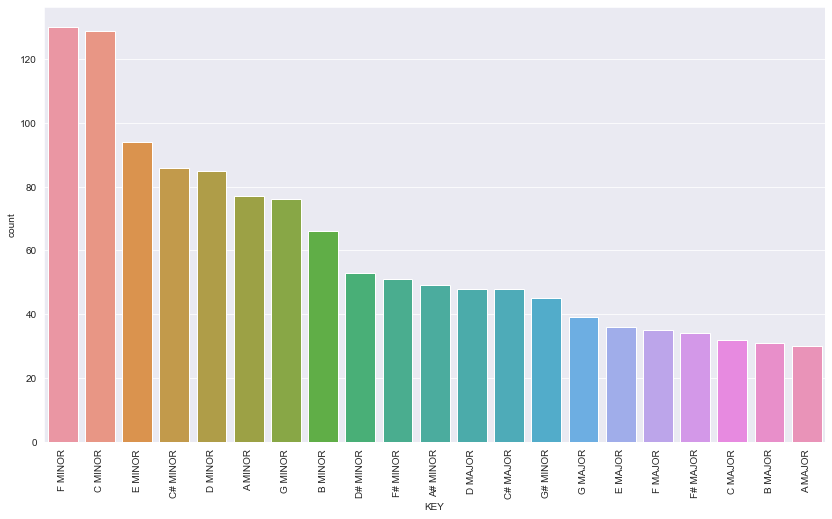

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=allAnnotations, x="KEY", order=allAnnotations["KEY"].value_counts().index)
plt.xticks(rotation=90)

What about the numeric key values?

<AxesSubplot:xlabel='NUMERIC KEY', ylabel='count'>

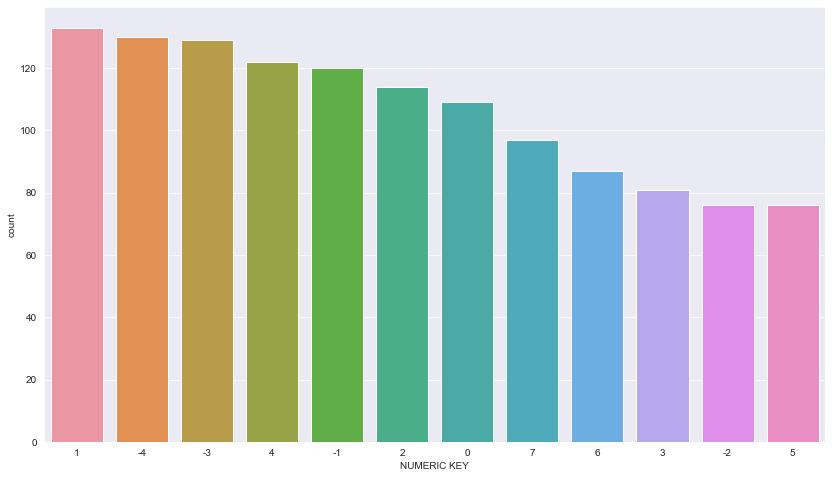

In [20]:
sns.countplot(data=allAnnotations, x="NUMERIC KEY", order=allAnnotations["NUMERIC KEY"].value_counts().index)

What about the mode?

<AxesSubplot:xlabel='MODE', ylabel='count'>

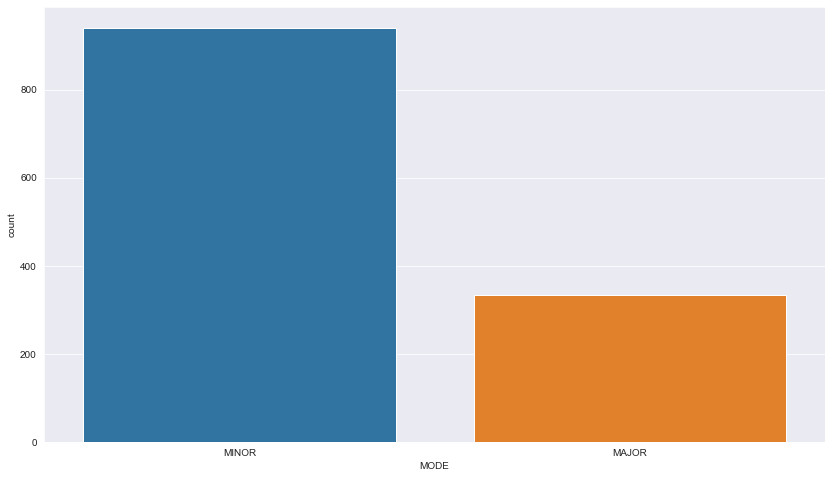

In [21]:
sns.countplot(data=allAnnotations, x="MODE", order=allAnnotations["MODE"].value_counts().index)

If a program simply guessed the most common numeric key and most common mode, how accurate would it be?

In [22]:
keyOnly = allAnnotations["KEY"].value_counts()[0] / allAnnotations["KEY"].count()
numKeyOnly = allAnnotations["NUMERIC KEY"].value_counts()[0] / allAnnotations["NUMERIC KEY"].count()
modeOnly = allAnnotations["MODE"].value_counts()[0] / allAnnotations["MODE"].count()

print(f"Guess most common key:               {keyOnly * 100:.3f}%")
print(f"Guess most common numeric key value: {numKeyOnly * 100:.3f}%")
print(f"Guess most common mode:              {modeOnly * 100:.3f}%")
print(f"Guess both numeric key and mode:     {numKeyOnly * modeOnly * 100:.3f}%")

Guess most common key:               10.204%
Guess most common numeric key value: 8.556%
Guess most common mode:              73.862%
Guess both numeric key and mode:     6.319%


## Naive Key Estimator


A naive approach would be to compute the relative frequency of occurence of each of the 12 notes, and then compare that to the expected frequencies for each of the keys. The key which matches the best would be the *estimated* key.

First we create a function that, given a key, will return a set of numbers which are the integer offsets from C.

In [23]:
ALL_KEYS = {
    # Major Scales
    "C Major", "C♯ Major", "D♭ Major", "D Major", "E♭ Major", "E Major", "F Major", "F♯ Major", "G♭ Major",
    "G Major", "A♭ Major", "A Major", "B♭ Major", "B Major", "C♭ Major",

    # (Natural) Minor Scales
    "C Minor", "C♯ Minor", "D Minor", "D♯ Minor", "E♭ Minor", "E Minor", "F Minor", "F♯ Minor", "G Minor",
    "G♯ Minor", "A♭ Minor", "A Minor", "A♯ Minor", "B♭ Minor", "B Minor"
}

def get_notes_in_key(music_key) :
    # Fancify the key
    fancy_key = fancify_music_string(music_key)

    # Get the note offsets and return them
    if fancy_key == "C Major":
        return {0, 2, 4, 5, 7, 9, 11}
    elif fancy_key == "G Major":
        return {7, 9, 11, 0, 2, 4, 6}
    elif fancy_key == "D Major":
        return {2, 4, 6, 7, 9, 11, 1}
    elif fancy_key == "A Major":
        return {9, 11, 1, 2, 4, 6, 8}
    elif fancy_key == "E Major":
        return {4, 6, 8, 9, 11, 1, 3}
    elif fancy_key == "B Major" or fancy_key == "C♭ Major":
        return {11, 1, 3, 4, 6, 8, 10}
    elif fancy_key == "F♯ Major" or fancy_key == "G♭ Major":
        return {6, 8, 10, 11, 1, 3, 5}
    elif fancy_key == "C♯ Major" or fancy_key == "D♭ Major":
        return {1, 3, 5, 6, 8, 10, 0}
    elif fancy_key == "F Major":
        return {5, 7, 9, 10, 0, 2, 4}
    elif fancy_key == "B♭ Major":
        return {10, 0, 2, 3, 5, 7, 9}
    elif fancy_key == "E♭ Major":
        return {3, 5, 7, 8, 10, 0, 2}
    elif fancy_key == "A♭ Major":
        return {8, 10, 0, 1, 3, 5, 7}

    elif fancy_key == "A Minor":
        return {9, 11, 0, 2, 4, 5, 7}
    elif fancy_key == "E Minor":
        return {4, 6, 7, 9, 11, 0, 2}
    elif fancy_key == "B Minor":
        return {11, 1, 2, 4, 6, 7, 9}
    elif fancy_key == "F♯ Minor":
        return {6, 8, 9, 11, 1, 2, 4}
    elif fancy_key == "C♯ Minor":
        return {1, 3, 4, 6, 8, 9, 11}
    elif fancy_key == "G♯ Minor":
        return {8, 10, 11, 1, 3, 4, 6}
    elif fancy_key == "D♯ Minor":
        return {3, 5, 6, 8, 10, 11, 1}
    elif fancy_key == "A♯ Minor":
        return {10, 0, 1, 3, 5, 6, 8}
    elif fancy_key == "D Minor":
        return {2, 4, 5, 7, 9, 10, 0}
    elif fancy_key == "G Minor":
        return {7, 9, 10, 0, 2, 3, 5}
    elif fancy_key == "C Minor":
        return {0, 2, 3, 5, 7, 8, 10}
    elif fancy_key == "F Minor":
        return {5, 7, 8, 10, 0, 1, 3}
    elif fancy_key == "B♭ Minor":
        return {10, 0, 1, 3, 5, 6, 8}
    elif fancy_key == "E♭ Minor":
        return {3, 5, 6, 8, 10, 11, 1}
    elif fancy_key == "A♭ Minor":
        return {8, 10, 11, 1, 3, 4, 6}

    else:
        raise ValueError(f"Unknown key {fancy_key}")

Now we define a function that converts the notes in a key into an *expected* vector.


In [24]:
import numpy as np

def notes_to_vector_form(set_of_note_numbers):
    # Define a 12-dimensional vector (because there are 12 unique note numbers)
    vector = np.zeros((12,))

    # For each of the numbers present in the `set_of_note_numbers`, set that position to 1
    for note in set_of_note_numbers:
        vector[note] = 1

    # Return the vector
    return vector


# Example: C Major
notesInKey = get_notes_in_key("C Major")
print(notesInKey)
print(notes_to_vector_form(notesInKey))

{0, 2, 4, 5, 7, 9, 11}
[1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1.]


Also create a function that generates the VQT based off of an audio file.


In [25]:
import librosa

def note_number_to_freq(note_number: int) -> float:
    return 2 ** ((note_number - 57) / 12) * 440


def samples_to_vqt(sample_rate: float, samples: np.array, hop_length: int = 1024, f_min=note_number_to_freq(0),
                   n_bins: int = 240, bins_per_octave=24):

    # Generate the VQT of the audio file
    vqt = librosa.vqt(samples, sr=sample_rate, hop_length=hop_length, fmin=f_min, n_bins=n_bins,
                      bins_per_octave=bins_per_octave)

    # Keep only the magnitude of the complex numbers from the VQT
    vqt = np.abs(vqt)

    # Return the VQT
    return vqt

def generate_vqt(audio_file):
    # Generate the path to the audio file
    path = AUDIO_DATA_FOLDER / audio_file

    # Get the audio samples from the file
    y, sr = librosa.load(str(path.absolute()), sr=None)

    # Get VQT magnitudes
    mags = samples_to_vqt(sr, y)

    # Return the magnitudes
    return mags


Now we need a function that sums up the magnitude values for each one of the 12 note categories.

In [26]:
def summed_magnitudes(mags, bins_per_note):
    # Get shape of magnitude matrix
    num_freq_bins, num_cols = mags.shape

    # Sum the elements row-wise
    row_sum = np.sum(mags, axis=1)

    # Now sum according to notes
    note_sums = np.zeros((12,))
    for i in range(num_freq_bins):
        note_sums[(i // bins_per_note) % 12] += row_sum[i]

    return note_sums


Normalize the summed magnitudes to the interval $[0, 7]$. This is because there are only 8 notes that are in scale for each key, so the total sum of the magnitudes should equal 7.


In [27]:
def normalize_note_sums(note_sums):
    # Calculate total
    total = np.sum(note_sums)

    # Normalize each value in `note_sums`
    note_sums = note_sums / total * 7

    # Return normalized array
    return note_sums


One last function: one that helps determine the distance between two vectors.

In [28]:
def get_dist(a_vect, b_vect):
    return np.linalg.norm(a_vect - b_vect)

Let's test on one file.

In [29]:
N_BINS = 240
BINS_PER_OCTAVE = 24
BINS_PER_NOTE = 2

magnitudes = generate_vqt("167955.LOFI.mp3")
summedMags = summed_magnitudes(magnitudes, BINS_PER_NOTE)
normalizedMags = normalize_note_sums(summedMags)

print(normalizedMags)


/Users/Guest1/miniforge3/envs/Music-Key-Estimation/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


[0.47603282 0.45169181 0.43491675 0.57522407 0.645844   0.54103796
 0.55654826 0.6429572  0.79722648 0.6913271  0.60025478 0.58693876]


In [30]:
records = []

for key in ALL_KEYS:
    # Get the expected frequencies
    expectedVect = notes_to_vector_form(get_notes_in_key(key))

    # Compare with actual frequencies and find distance
    dist = get_dist(expectedVect, normalizedMags)

    # Add to records
    records.append([key, dist])

# Sort from lowest to highest
records = sorted(records, key=lambda elem: elem[1])
print(records)

[['C♯ Minor', 1.6100775443415887], ['E Major', 1.6100775443415887], ['B Major', 1.6656813425675892], ['A♭ Minor', 1.6656813425675892], ['C♭ Major', 1.6656813425675892], ['G♯ Minor', 1.6656813425675892], ['F♯ Minor', 1.6949821045885851], ['A Major', 1.6949821045885851], ['D♯ Minor', 1.7274566302163712], ['G♭ Major', 1.7274566302163712], ['F♯ Major', 1.7274566302163712], ['E♭ Minor', 1.7274566302163712], ['A♭ Major', 1.7415798575150965], ['F Minor', 1.7415798575150965], ['E♭ Major', 1.7511854633602058], ['C Minor', 1.7511854633602058], ['G Major', 1.7699776510959842], ['E Minor', 1.7699776510959842], ['D Minor', 1.7712169329211191], ['F Major', 1.7712169329211191], ['C Major', 1.7787190553381724], ['A Minor', 1.7787190553381724], ['D Major', 1.7836767906812132], ['B Minor', 1.7836767906812132], ['D♭ Major', 1.7905078304863802], ['A♯ Minor', 1.7905078304863802], ['C♯ Major', 1.7905078304863802], ['B♭ Minor', 1.7905078304863802], ['G Minor', 1.8106488588955145], ['B♭ Major', 1.810648858895

What is the accuracy on a small sample of audio files?

Using a 'demerit' system, where more points is bad, find the correct key in the ranked records. Number of points scored is the position that the correct key is placed in the ranked records (zero-index).


In [31]:
from tqdm.notebook import tqdm

score = 0

for file in tqdm(relevantAudioFiles, desc="Iterating through files"):
    # Get the ID of the audio file
    id_ = int(file.split(".")[0])

    magnitudes = generate_vqt(file)
    summedMags = summed_magnitudes(magnitudes, BINS_PER_NOTE)
    normalizedMags = normalize_note_sums(summedMags)

    records = []

    for key in ALL_KEYS:
        # Get the expected frequencies
        expectedVect = notes_to_vector_form(get_notes_in_key(key))

        # Compare with actual frequencies and find distance
        dist = get_dist(expectedVect, normalizedMags)

        # Add to records
        records.append([key, dist])

    # Sort from lowest to highest
    records = sorted(records, key=lambda elem: elem[1])

    # What is the correct key?
    correctKey = fancify_music_string(relevantAnnotations.loc[relevantAnnotations["ID"] == id_]["KEY"].iloc[0].title())

    # Calculate score
    for i, (key, dist) in enumerate(records):
        if key == correctKey:
            score += i
            break

print("Demerit score:", score)

Iterating through files:   0%|          | 0/21 [00:00<?, ?it/s]

/Users/Guest1/miniforge3/envs/Music-Key-Estimation/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/Users/Guest1/miniforge3/envs/Music-Key-Estimation/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/Users/Guest1/miniforge3/envs/Music-Key-Estimation/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/Users/Guest1/miniforge3/envs/Music-Key-Estimation/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/Users/Guest1/miniforge3/envs/Music-Key-Estimation/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/Users/Guest1/m

Demerit score: 270


A demerit score of 270 for 21 files means that, on average, the correct key is ~12.9 steps away from the predicted key. This is not good.
